# Airbnb inititial wrangling and analysis

**Research Problem**:
Is your host profile attractive enough?

**Motivation**:
An attractive profile should attract travelers to book a house listing at a frequent base. The result of this is that a majority of nights in a year are booked by travelers. Host usally put the most beutiful photos of their listing on Airbnb, making them look like 5-star hotels. In fact, the data source website shows that a large number of listings were vaccant in the last 12 months (0 nights booked). Why some listings didn't gain attention might correlate with the hosts' profile: for example, their occupations, word choices in writing the host and listing summary.

**Method**:
* Define profile attractiveness = 
(Occupancy in the last 12 months)/(number of words in the listing description). 
* **First round prediction**: name of the listing, host_is_superhost, host_has_Profile_pic

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
## load Data
calendar = pd.read_csv("calendar.csv")
listings = pd.read_csv("listings.csv")

## Sample the first 1000 observations of listings
listings = listings.loc[0:1000, ["id", \
    "description", "host_name", "host_is_superhost"]]
calendar = calendar[["listing_id", "date", "available"]]

In [6]:
calendar.info()
calendar.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1048575 non-null  int64 
 1   date        1048575 non-null  object
 2   available   1048575 non-null  object
dtypes: int64(1), object(2)
memory usage: 24.0+ MB


,listing_id
count,1.048575e+06
mean,1.320461e+07
std,5.983513e+06
min,1.419000e+03
25%,7.564933e+06
50%,1.447197e+07
75%,1.822167e+07
max,2.781125e+07


In [15]:
calendar.date = pd.to_datetime(calendar.date, infer_datetime_format=True)
calendar.date.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1048575 entries, 0 to 1048574
Series name: date
Non-Null Count    Dtype         
--------------    -----         
1048575 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 8.0 MB


In [16]:
calendar.available = calendar.available.map({"f": False, "t": True})
calendar.available.info()
calendar.available.describe()

<class 'pandas.core.series.Series'>
RangeIndex: 1048575 entries, 0 to 1048574
Series name: available
Non-Null Count    Dtype
--------------    -----
1048575 non-null  bool 
dtypes: bool(1)
memory usage: 1.0 MB


count     1048575
unique          2
top         False
freq       764317
Name: available, dtype: object

In [21]:
calendar["year"] = calendar.date.dt.year
calendar["year"].describe()

count    1.048575e+06
mean     2.022684e+03
std      4.648842e-01
min      2.022000e+03
25%      2.022000e+03
50%      2.023000e+03
75%      2.023000e+03
max      2.023000e+03
Name: year, dtype: float64

In [28]:
listing_availability = calendar.groupby(["listing_id"])[["available"]].sum().reset_index()
listing_availability

,listing_id,available
0,1419,0
1,8077,365
2,27423,18
3,28160,302
4,30931,365
...,...,...
2868,27787978,0
2869,27797167,0
2870,27807353,0
2871,27808101,0


In [38]:
## Right join two tables
sample_joined = listings.merge(right = listing_availability, left_on="id",\
    right_on = "listing_id", how = "left" left_index = False)

In [62]:
sample_joined["descr_word_count"] = sample_joined["description"].str.split().str.len()

In [63]:
sample_joined["des_attractiveness"] = (365 - sample_joined.available)/\
    sample_joined.descr_word_count
sample_joined["des_attractiveness"][1:10]

1         NaN
2    4.802632
3    2.851562
4    1.134146
5         NaN
6    0.230303
7         NaN
8         NaN
9    3.625000
Name: des_attractiveness, dtype: float64

(array([360.,  83.,  17.,  16.,   8.,   6.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ,
        27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5, 50. ]),
 <BarContainer object of 20 artists>)

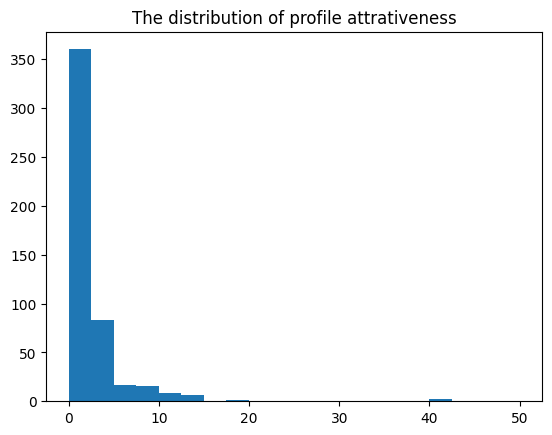

In [72]:
plt.title("The distribution of profile attrativeness") 
plt.hist(sample_joined["des_attractiveness"], range=[0,50], bins=20)

In [73]:
three_quantiles = sample_joined.des_attractiveness.quantile([0.33, 0.66])
three_quantiles

0.33    0.983120
0.66    2.281824
Name: des_attractiveness, dtype: float64

Define every description attrativeness below 33% quantile as "unattractive", between 33% and 66% quantile as "somewhat attrative", above 66% quantile as "attractive".

In [104]:
pd.isna(np.nan)
def attractive_class(score):
    if pd.isna(score):
        return np.NaN
    if score < three_quantiles.iloc[0]: 
        return "unattractive"
    elif score > three_quantiles.iloc[1]:
        return "attrative"
    else:
        return "somewhat attrative"
# attractive_class(0.5)
# attractive_class(1.5)
# attractive_class(3)
# attractive_class(np.NaN)

sample_joined["attrac_class"] = sample_joined.des_attractiveness.map(attractive_class)
sample_joined["attrac_class"][0:10]

0    somewhat attrative
1                   NaN
2             attrative
3             attrative
4    somewhat attrative
5                   NaN
6          unattractive
7                   NaN
8                   NaN
9             attrative
Name: attrac_class, dtype: object